# Starbucks Capstone Challenge - Predictive and Modelling

## Introduction

Offer Selection

* Remove unsuccessful offers
* Strip the ID and perform a classifier

Receives Offer or Not

* Receives offer if, offer successful and total spent is 20 (10 from promo, + additional product) 

Combination of both will give better results in incremental profit and IRR.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sb_capstone.wrangling import (
    clean_transcript_group
)

%matplotlib inline

In [3]:
transcript_group = pd.read_csv("../data/processed/transcript_group.csv")
transcript_group = clean_transcript_group(transcript_group)

transcript_group.head()

,id,wave,received,viewed,completed,amount,reward,non_offer_amount,mapped_offer,offer_type,...,web,email,mobile,social,gender,age,income,membership_year,membership_month,membership_day
0,1,2,True,True,False,0.00,0.0,0.00,10,discount,...,True,True,True,False,U,NaN,NaN,2017,2,12
1,2,2,False,False,False,0.00,0.0,0.00,0,no_offer,...,False,False,False,False,F,55.0,112000.0,2017,7,15
2,3,2,True,True,False,0.00,0.0,0.00,4,bogo,...,True,True,True,False,U,NaN,NaN,2018,7,12
3,4,2,True,True,True,19.67,0.0,29.72,8,informational,...,False,True,True,True,F,75.0,100000.0,2017,5,9
4,5,2,False,False,False,0.00,0.0,3.50,0,no_offer,...,False,False,False,False,U,NaN,NaN,2017,8,4


In [4]:
transcript_group.dtypes

id                     int64
wave                   int64
received                bool
viewed                  bool
completed               bool
amount               float64
reward               float64
non_offer_amount     float64
mapped_offer        category
offer_type          category
difficulty           float64
duration             float64
web                     bool
email                   bool
mobile                  bool
social                  bool
gender              category
age                  float64
income               float64
membership_year        int64
membership_month       int64
membership_day         int64
dtype: object

## Machine Learning Imputation

### Imputing Age

In [5]:
transcript_group[transcript_group.age.isna()]

,id,wave,received,viewed,completed,amount,reward,non_offer_amount,mapped_offer,offer_type,...,web,email,mobile,social,gender,age,income,membership_year,membership_month,membership_day
0,1,2,True,True,False,0.00,0.0,0.0,10,discount,...,True,True,True,False,U,NaN,NaN,2017,2,12
2,3,2,True,True,False,0.00,0.0,0.0,4,bogo,...,True,True,True,False,U,NaN,NaN,2018,7,12
4,5,2,False,False,False,0.00,0.0,3.5,0,no_offer,...,False,False,False,False,U,NaN,NaN,2017,8,4
6,7,2,True,True,False,0.00,0.0,0.0,2,bogo,...,True,True,True,True,U,NaN,NaN,2017,9,25
7,8,2,True,False,False,0.00,0.0,0.0,1,bogo,...,False,True,True,True,U,NaN,NaN,2017,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101980,16981,1,True,True,False,1.88,0.0,0.0,6,discount,...,True,True,True,True,U,NaN,NaN,2016,9,1
101982,16983,1,True,True,True,6.48,2.0,0.0,7,discount,...,True,True,True,True,U,NaN,NaN,2016,4,15
101989,16990,1,True,True,False,0.00,0.0,0.0,6,discount,...,True,True,True,True,U,NaN,NaN,2018,3,5
101991,16992,1,True,False,False,0.13,0.0,0.0,1,bogo,...,False,True,True,True,U,NaN,NaN,2016,1,16


Selecting only the fields that relates to the customer.

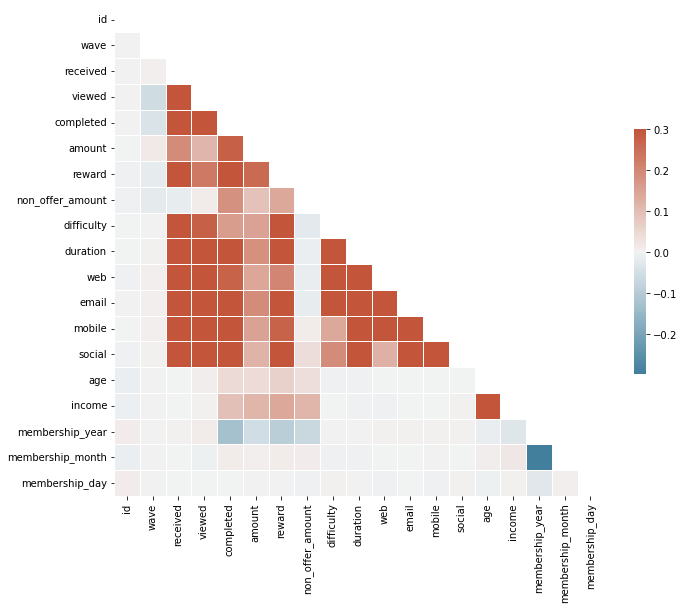

In [6]:
corr = transcript_group.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Fields removed**

* `difficulty`, `offer_type` and `duration` are related to offer
* `web`, `email`, `mobile`, `social` as it is related to offer, they are offered randomly, not relating to age

In [30]:
cols = [
    "wave", 
    "received", 
    "viewed", 
    "completed", 
    "amount", 
    "reward", 
    "non_offer_amount", 
    "age",
    "gender"
]

def convert_gender(x):
    if x == "M":
        return 1
    elif x== "F":
        return 0
    else:
        return np.NaN

transcript_imp = transcript_group.copy()

transcript_imp.received = transcript_imp.received.astype(int)
transcript_imp.viewed = transcript_imp.viewed.astype(int)
transcript_imp.completed = transcript_imp.completed.astype(int)
transcript_imp.gender = transcript_imp.gender.astype(str).apply(convert_gender)

transcript_imp = transcript_imp[cols]

transcript_imp.head()

,wave,received,viewed,completed,amount,reward,non_offer_amount,age,gender
0,2,1,1,0,0.00,0.0,0.00,NaN,NaN
1,2,0,0,0,0.00,0.0,0.00,55.0,0.0
2,2,1,1,0,0.00,0.0,0.00,NaN,NaN
3,2,1,1,1,19.67,0.0,29.72,75.0,0.0
4,2,0,0,0,0.00,0.0,3.50,NaN,NaN


In [31]:
transcript_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   wave              102000 non-null  int64  
 1   received          102000 non-null  int32  
 2   viewed            102000 non-null  int32  
 3   completed         102000 non-null  int32  
 4   amount            102000 non-null  float64
 5   reward            102000 non-null  float64
 6   non_offer_amount  102000 non-null  float64
 7   age               88950 non-null   float64
 8   gender            87678 non-null   float64
dtypes: float64(5), int32(3), int64(1)
memory usage: 5.8 MB


In [32]:
# transcript_imp = pd.concat([transcript_imp, pd.get_dummies(transcript_imp.gender)], axis=1)
# transcript_imp = transcript_imp.drop(columns=["U", "gender"])
# transcript_imp.head()

In [33]:
# offer_dummies = pd.get_dummies(transcript_imp.mapped_offer)
# offer_dummies.columns = offer_dummies.columns.astype(str)
# transcript_imp = pd.concat([transcript_imp, offer_dummies], axis=1)
# transcript_imp = transcript_imp.drop(columns=["mapped_offer"])
# transcript_imp.head()

In [34]:
# transcript_imp = transcript_imp[transcript_imp.O != 1]
# transcript_imp = transcript_imp.drop(columns=["O", "F"])
# transcript_imp.head()

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

y = transcript_imp.age
X = transcript_imp.loc[:, ~transcript_imp.columns.isin(["age"])]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [36]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
transcript_age = imputer.fit_transform(transcript_imp)

In [37]:
transcript_age = pd.DataFrame(transcript_age, columns=transcript_imp.columns)
transcript_age

,wave,received,viewed,completed,amount,reward,non_offer_amount,age,gender
0,2.0,1.0,1.0,0.0,0.00,0.0,0.00,53.005740,0.659228
1,2.0,0.0,0.0,0.0,0.00,0.0,0.00,55.000000,0.000000
2,2.0,1.0,1.0,0.0,0.00,0.0,0.00,53.005740,0.659228
3,2.0,1.0,1.0,1.0,19.67,0.0,29.72,75.000000,0.000000
4,2.0,0.0,0.0,0.0,0.00,0.0,3.50,54.330775,0.584584
...,...,...,...,...,...,...,...,...,...
101995,1.0,0.0,0.0,0.0,0.00,0.0,6.59,45.000000,0.000000
101996,1.0,1.0,1.0,0.0,0.00,0.0,2.93,61.000000,1.000000
101997,1.0,1.0,0.0,0.0,0.00,0.0,0.00,49.000000,1.000000
101998,1.0,0.0,0.0,0.0,0.00,0.0,18.00,83.000000,0.000000
